<a href="https://colab.research.google.com/github/saeedzou/DeepLearning1401-01/blob/main/Assignment%204/q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# import necessary libraries for pytorch to train a sequence-to-sequence model using LSTM cells to generate poems of Ferdousi
# the dataset is in ferdousi.txt which is in persian
# the model is trained on a GPU
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
# # for persian
# !pip install hazm -q
# from hazm import *
import string
from collections import Counter
import random

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
!git clone https://github.com/amnghd/Persian_poems_corpus.git
!cp Persian_poems_corpus/original/ferdousi.txt .
!rm -rf Persian_poems_corpus

Cloning into 'Persian_poems_corpus'...
remote: Enumerating objects: 159, done.
remote: Total 159 (delta 0), reused 0 (delta 0), pack-reused 159
Receiving objects: 100% (159/159), 45.21 MiB | 12.82 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (148/148), done.


In [17]:
class Vocabulary:
    def __init__(self, poem_path, threshold):
        self.poem_path = poem_path
        self.threshold = threshold
        self.load_poem()
        self.build_vocab()
        
    def load_poem(self):
        with open(self.poem_path, 'r', encoding='utf-8') as f:
            poem = [line.strip() for line in f.readlines()]
        poem = poem[2:]
        poem = poem[:-1] if len(poem) % 2 == 1 else poem
        poem = [[poem[i], poem[i+1]] for i in range(0, len(poem), 2)]
        poem = [mesra[0] + ' <sep> ' + mesra[1] for mesra in poem]
        punctuations = string.punctuation + '«»،؛؟'
        self.lines = [[word.lower() for word in line.split() if word not in punctuations] for line in poem]
    
    def build_vocab(self):
        words = [word for line in self.lines for word in line]
        word_counts = Counter(words)
        words = [word for word, count in word_counts.items() if count >= self.threshold]
        self.word2idx = {word: idx for idx, word in enumerate(words)}
        self.word2idx['<pad>'] = len(self.word2idx)
        self.word2idx['<sos>'] = len(self.word2idx)
        self.word2idx['<eos>'] = len(self.word2idx)
        self.word2idx['<unk>'] = len(self.word2idx)
        self.word2idx['<sep>'] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

In [18]:
class FerdousiDataset(torch.utils.data.Dataset):
    def __init__(self, poem_path, vocab):
        self.poem_path = poem_path
        self.vocab = vocab
        self.load_poem()

    def __len__(self):
        return len(self.poem) - 1

    def __getitem__(self, idx):
        return self.poem[idx], self.poem[idx + 1]

    def load_poem(self):
        with open(self.poem_path, 'r', encoding='utf-8') as f:
            poem = [line.strip() for line in f.readlines()]
        poem = poem[2:]
        poem = poem[:-1] if len(poem) % 2 == 1 else poem
        poem = [[poem[i], poem[i + 1]] for i in range(0, len(poem), 2)]
        poem = [mesra[0] + ' <sep> ' + mesra[1] for mesra in poem]
        poem = [word_tokenize(line) for line in poem]
        punctuations = string.punctuation + '«»،؛؟'
        poem = [[word for word in line if word not in punctuations] for line in poem]
        poem = [line for line in poem if len(line) > 0]
        poem = [[word for word in line if len(word) > 1] for line in poem]
        self.max_len = max([len(line) for line in poem])
        poem = [line + ['<pad>'] * (self.max_len - len(line)) for line in poem]
        poem = [['<sos>'] + line + ['<eos>'] for line in poem]

        # Create word vectors using the vocabulary
        self.poem = []
        for line in poem:
            line_vec = []
            for word in line:
                if word in self.vocab.word2idx:
                    line_vec.append(self.vocab.word2idx[word])
                else:
                    line_vec.append(self.vocab.word2idx['<unk>'])
            self.poem.append(line_vec)
        self.poem = torch.tensor(self.poem).long()

vocab = Vocabulary('ferdousi.txt', 2)
# create a dataset object
dataset = FerdousiDataset('ferdousi.txt', vocab)
# split the dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
# create a dataloader for train and test
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, p_drop=0.1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(p_drop)

    def forward(self, x, hidden=None, cell=None):
        # x.shape = (batch_size, seq_len)
        embedding = self.dropout(self.embedding(x))
        # embedding.shape = (batch_size, seq_len, embedding_size)
        if hidden is None and cell is None:
            hidden = torch.zeros((self.num_layers, x.shape[0], self.hidden_size), device=x.device)
            cell = torch.zeros((self.num_layers, x.shape[0], self.hidden_size), device=x.device)
        outputs, (hidden, cell) = self.rnn(embedding, (hidden, cell))
        # outputs.shape = (batch_size, seq_len, hidden_size)
        # hidden.shape = (num_layers, batch_size, hidden_size)
        # cell.shape = (num_layers, batch_size, hidden_size)
        return hidden, cell

# define the decoder class and use the encoder.embedding as the embedding layer
class Decoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, p_drop=0.1):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = encoder.embedding
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p_drop)

    def forward(self, x, hidden, cell):
        # x.shape = (batch_size, 1)
        x = x.unsqueeze(1)
        # x.shape = (batch_size, 1, 1)
        embedding = self.dropout(self.embedding(x))
        # embedding.shape = (batch_size, 1, embedding_size)
        outputs, (hidden, cell) = self.rnn(embedding, (hidden, cell))
        # outputs.shape = (batch_size, 1, hidden_size)
        # hidden.shape = (num_layers, batch_size, hidden_size)
        # cell.shape = (num_layers, batch_size, hidden_size)
        predictions = self.fc(outputs)
        # predictions.shape = (batch_size, 1, output_size)
        predictions = predictions.squeeze(1)
        # predictions.shape = (batch_size, output_size)
        return predictions, hidden, cell

In [20]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_forcing_ratio=0.8):
        # source.shape = (batch_size, source_seq_len)
        # target.shape = (batch_size, target_seq_len)
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_vocab_size = len(dataset.vocab.word2idx)
        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(device)
        hidden, cell = self.encoder(source)
        # hidden.shape = (num_layers, batch_size, hidden_size)
        # cell.shape = (num_layers, batch_size, hidden_size)
        x = target[:, 0]
        # x.shape = (batch_size)
        for t in range(1, target_len):
            output, hidden, cell = self.decoder(x, hidden, cell)
            # output.shape = (batch_size, target_vocab_size)
            outputs[:, t] = output
            best_guess = output.argmax(1)
            x = target[:, t] if random.random() < teacher_forcing_ratio else best_guess
        return outputs

In [21]:
# encoder hyperparameters
input_size_encoder = len(dataset.vocab.word2idx)
encoder_embedding_size = 200
hidden_size = 128
num_layers = 2
# define the encoder
encoder = Encoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers).to(device)
# decoder hyperparameters
input_size_decoder = len(dataset.vocab.word2idx)
output_size = len(dataset.vocab.word2idx)
decoder_embedding_size = 200
hidden_size = 128
num_layers = 2
# define the decoder
decoder = Decoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers).to(device)
num_epochs = 50
learning_rate = 1e-3
# initialize the network
encoder_net = Encoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers).to(device)
decoder_net = Decoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers).to(device)
model = Seq2Seq(encoder_net, decoder_net).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.word2idx['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
# define a function that takes a tensor of indices and returns a string and removes pad and end and start tokens
def tensor2string(tensor):
    # tensor.shape = (seq_len)
    words = [dataset.vocab.idx2word[idx.item()] for idx in tensor]
    words = [word for word in words if word not in ['<pad>', '<sos>', '<eos>']]
    return ' '.join(words)

# define a function that generates a verse
def generate_verse(model, source, device, max_len=20):
    source = source.unsqueeze(0)
    model.eval()
    # dont forget to move to device
    with torch.no_grad():
        hidden, cell = model.encoder(source.to(device))
        # hidden.shape = (num_layers, batch_size, hidden_size)
        # cell.shape = (num_layers, batch_size, hidden_size)
        x = torch.tensor([dataset.vocab.word2idx['<sos>']]).to(device)
        outputs = []
        for t in range(max_len):
            output, hidden, cell = model.decoder(x, hidden, cell)
            # output.shape = (1, output_size)
            best_guess = output.argmax(1)
            outputs.append(best_guess.item())
            x = best_guess
            if best_guess.item() == dataset.vocab.word2idx['<eos>']:
                break
    return tensor2string(torch.tensor(outputs))

In [23]:
# define a function that trains the model
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(num_epochs):
        train_loss = 0
        train_accuracy = 0
        idx = random.randint(0, len(train_dataset))
        verse = train_dataset[idx][0].to(device)
        print(generate_verse(model, verse, device=device))
        model.train()
        for (source, target) in train_loader:
            source = source.to(device)
            target = target.to(device)
            outputs = model(source, target)
            # outputs.shape = (batch_size, target_seq_len, output_size)
            outputs = outputs[:, 1:].reshape(-1, outputs.shape[2])
            # outputs.shape = (batch_size * target_seq_len, output_size)
            target = target[:, 1:].reshape(-1)
            # target.shape = (batch_size * target_seq_len)
            loss = criterion(outputs, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            top_p, top_class = outputs.topk(1, dim=1)
            # top_p.shape = (batch_size * target_seq_len, 1)
            # top_class.shape = (batch_size * target_seq_len, 1)
            equals = top_class == target.view(*top_class.shape)
            # equals.shape = (batch_size * target_seq_len, 1)
            train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy / len(train_loader))
        model.eval()
        val_loss = 0
        val_accuracy = 0
        with torch.no_grad():
            for (source, target) in val_loader:
                source = source.to(device)
                target = target.to(device)
                outputs = model(source, target)
                # outputs.shape = (batch_size, target_seq_len, output_size)
                outputs = outputs[:, 1:].reshape(-1, outputs.shape[2])
                # outputs.shape = (batch_size * target_seq_len, output_size)
                target = target[:, 1:].reshape(-1)
                # target.shape = (batch_size * target_seq_len)
                loss = criterion(outputs, target)
                val_loss += loss.item()
                top_p, top_class = outputs.topk(1, dim=1)
                # top_p.shape = (batch_size * target_seq_len, 1)
                # top_class.shape = (batch_size * target_seq_len, 1)
                equals = top_class == target.view(*top_class.shape)
                # equals.shape = (batch_size * target_seq_len, 1)
                val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy / len(val_loader))
        print(f'Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Accuracy: {train_accuracies[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Accuracy: {val_accuracies[-1]:.4f}')
    return train_losses, val_losses, train_accuracies, val_accuracies

In [24]:
train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, test_loader, criterion, optimizer, num_epochs, device)

خواهم شارهٔ شارهٔ شارهٔ بیندت ساله بیندت ساله کارآن چندشان زگرد بکه نشناختند شهد بکه شهد شهد کهترانند انگاه بلاغت
Epoch 1/50 | Train Loss: 5.9615 | Train Accuracy: 0.1232 | Val Loss: 5.7065 | Val Accuracy: 0.1305
به از که از بر <unk> <unk> <unk> به بر بر بر به راه اوی
Epoch 2/50 | Train Loss: 5.5735 | Train Accuracy: 0.1358 | Val Loss: 5.5037 | Val Accuracy: 0.1399
چو گفت با شاه <unk> <unk> <unk> <unk> از بر <unk> بر <unk> به دست اوی اوی
Epoch 3/50 | Train Loss: 5.3755 | Train Accuracy: 0.1431 | Val Loss: 5.3624 | Val Accuracy: 0.1455
چو گفت که ای <unk> <unk> <unk> <unk> <unk> <unk> <unk> به راه به راه اوی اوی
Epoch 4/50 | Train Loss: 5.2138 | Train Accuracy: 0.1493 | Val Loss: 5.2461 | Val Accuracy: 0.1511
چو بشنید شد از <unk> <unk> <unk> <unk> از از بر او را به پای بود
Epoch 5/50 | Train Loss: 5.0755 | Train Accuracy: 0.1547 | Val Loss: 5.1433 | Val Accuracy: 0.1557
چو گفت با او <unk> <unk> <unk> که از <unk> <unk> به دست به دست به دست بود
Epoch 6/50 | Train Loss: 4.9671 | Train Accur

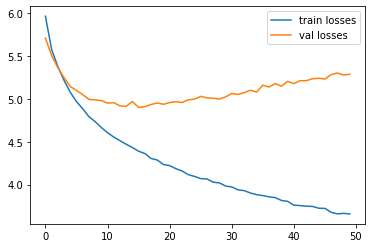

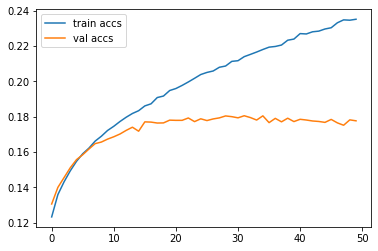

In [45]:
plt.plot(train_losses, label='train losses')
plt.plot(val_losses, label='val losses')
plt.legend()
plt.show()
plt.plot(train_accuracies, label='train accs')
plt.plot(val_accuracies, label='val accs')
plt.legend()
plt.show()

To generate verses I only select those generated verses that have unique words in them and their length is more than 12

In [43]:
# define a function that takes a tensor of indices and returns a string and removes pad and end and start tokens
def tensor2string(tensor):
    # tensor.shape = (seq_len)
    words = [dataset.vocab.idx2word[idx.item()] for idx in tensor]
    words = [word for word in words if word not in ['<pad>', '<sos>', '<eos>', '<unk>']]
    return ' '.join(words)
print("Some Generated Verses: ")
i = 0
while not i == 10:
  idx = random.randint(0, len(train_dataset))
  verse = train_dataset[idx][0].to(device)
  generated = generate_verse(model, verse, device=device)
  if len(generated.split()) > 12:
    counts = Counter(generated.split())
    counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    if counts[0][1] == 1:
      i += 1
      print(generated)

Some Generated Verses: 
کنون چون نشستیم با او که بر ما ربودی همی پشت گام پرند
چو از دور دیدند بر همی رفت با او به جای نو گام زن
سیاوش بدو گفت کای شهریار که من نیاید به کار زار سیر آر تاو
چنین گفت با شاه ایران که ای نامداران گردان من سخن در گمان یادگار بگیر را بخوان
چو از پیش او شد به بر آن بگشاد لب را بکشت جفت
پس آگاهی آمد به ایران سپاه که از خونشان شد آوردگاه سیاه آمدند
یکی نیزه انداخت بر گردنش به ابر اندر آورده روی زمین برزدند زدند
بگویم ترا هرچ گفتی بطوس به از تیرگیها بیفروزدش رنگ بوی مست جوی چنگ
بدو گفت بهرام کای شهریار که من نیاید به کار زار سیر آر خار خو
چو من بگذرم زین سپنجی سرای که تو را باشدت رهنمای خدای نشست دست پای


In [46]:
# define another encoder with Bidirectional GRU
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, p_drop=0.1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(p_drop)

    def forward(self, x):
        # x.shape = (batch_size, seq_len)
        embedding = self.dropout(self.embedding(x))
        # embedding.shape = (batch_size, seq_len, embedding_size)
        outputs, hidden = self.gru(embedding)
        # outputs.shape = (batch_size, seq_len, hidden_size * 2)
        # hidden.shape = (num_layers * 2, batch_size, hidden_size)
        return hidden

# define decoder with bidirectional GRU
class Decoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, p_drop=0.1):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = encoder.embedding
        self.rnn = nn.GRU(embedding_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # since bidirectional, so multiply by 2
        self.dropout = nn.Dropout(p_drop)

    def forward(self, x, hidden):
        # x.shape = (batch_size, 1)
        x = x.unsqueeze(1)
        # x.shape = (batch_size, 1, 1)
        embedding = self.dropout(self.embedding(x))
        # embedding.shape = (batch_size, 1, embedding_size)
        outputs, hidden = self.rnn(embedding, hidden)
        # outputs.shape = (batch_size, 1, hidden_size * 2)  # since bidirectional, so hidden_size * 2
        # hidden.shape = (num_layers * 2, batch_size, hidden_size)  # since bidirectional, so num_layers * 2
        predictions = self.fc(outputs)
        # predictions.shape = (batch_size, 1, output_size)
        predictions = predictions.squeeze(1)
        # predictions.shape = (batch_size, output_size)
        return predictions, hidden

In [53]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        # source.shape = (batch_size, source_seq_len)
        # target.shape = (batch_size, target_seq_len)
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_vocab_size = len(dataset.vocab.word2idx)
        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(device)
        hidden = self.encoder(source)
        # hidden.shape = (batch_size, 2*hidden_size)
        x = target[:, 0]
        # x.shape = (batch_size)
        for t in range(1, target_len):
            output, hidden = self.decoder(x, hidden)
            # output.shape = (batch_size, target_vocab_size)
            outputs[:, t] = output
            best_guess = output.argmax(1)
            x = target[:, t] if random.random() < teacher_forcing_ratio else best_guess
        return outputs


In [64]:
# hyperparameters
input_size_encoder = len(dataset.vocab.word2idx)
encoder_embedding_size = 200
hidden_size = 128
num_layers = 2
# define the encoder
encoder = Encoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers).to(device)
# hyperparameters
input_size_decoder = len(dataset.vocab.word2idx)
output_size = len(dataset.vocab.word2idx)
decoder_embedding_size = 200
hidden_size = 128
num_layers = 2
num_epochs = 25
# define the decoder
decoder = Decoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers).to(device)
model = Seq2Seq(encoder, decoder).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.word2idx['<pad>'])

In [65]:
# define a function that takes a tensor of indices and returns a string and removes pad and end and start tokens
def tensor2string(tensor):
    # tensor.shape = (seq_len)
    words = [dataset.vocab.idx2word[idx.item()] for idx in tensor]
    words = [word for word in words if word not in ['<pad>', '<sos>', '<eos>']]
    return ' '.join(words)

# define a function that generates a verse
def generate_verse_gru(model, source, device, max_len=20):
    source = source.unsqueeze(0)
    model.eval()
    # dont forget to move to device
    with torch.no_grad():
        hidden = model.encoder(source.to(device))
        # hidden.shape = (num_layers, batch_size, hidden_size)
        # cell.shape = (num_layers, batch_size, hidden_size)
        x = torch.tensor([dataset.vocab.word2idx['<sos>']]).to(device)
        outputs = []
        for t in range(max_len):
            output, hidden = model.decoder(x, hidden)
            # output.shape = (1, output_size)
            best_guess = output.argmax(1)
            outputs.append(best_guess.item())
            x = best_guess
            if best_guess.item() == dataset.vocab.word2idx['<eos>']:
                break
    return tensor2string(torch.tensor(outputs))

In [66]:
# define a function that trains the model
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, generate_verse):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(num_epochs):
        train_loss = 0
        train_accuracy = 0
        idx = random.randint(0, len(train_dataset))
        verse = train_dataset[idx][0].to(device)
        print(generate_verse(model, verse, device=device))
        model.train()
        for (source, target) in train_loader:
            source = source.to(device)
            target = target.to(device)
            outputs = model(source, target)
            # outputs.shape = (batch_size, target_seq_len, output_size)
            outputs = outputs[:, 1:].reshape(-1, outputs.shape[2])
            # outputs.shape = (batch_size * target_seq_len, output_size)
            target = target[:, 1:].reshape(-1)
            # target.shape = (batch_size * target_seq_len)
            loss = criterion(outputs, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            top_p, top_class = outputs.topk(1, dim=1)
            # top_p.shape = (batch_size * target_seq_len, 1)
            # top_class.shape = (batch_size * target_seq_len, 1)
            equals = top_class == target.view(*top_class.shape)
            # equals.shape = (batch_size * target_seq_len, 1)
            train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy / len(train_loader))
        model.eval()
        val_loss = 0
        val_accuracy = 0
        with torch.no_grad():
            for (source, target) in val_loader:
                source = source.to(device)
                target = target.to(device)
                outputs = model(source, target)
                # outputs.shape = (batch_size, target_seq_len, output_size)
                outputs = outputs[:, 1:].reshape(-1, outputs.shape[2])
                # outputs.shape = (batch_size * target_seq_len, output_size)
                target = target[:, 1:].reshape(-1)
                # target.shape = (batch_size * target_seq_len)
                loss = criterion(outputs, target)
                val_loss += loss.item()
                top_p, top_class = outputs.topk(1, dim=1)
                # top_p.shape = (batch_size * target_seq_len, 1)
                # top_class.shape = (batch_size * target_seq_len, 1)
                equals = top_class == target.view(*top_class.shape)
                # equals.shape = (batch_size * target_seq_len, 1)
                val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy / len(val_loader))
        print(f'Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Accuracy: {train_accuracies[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Accuracy: {val_accuracies[-1]:.4f}')
    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, test_loader, criterion, optimizer, num_epochs, device, generate_verse_gru)

فرهنگیان گرسیوزست زکار میش تنگست سرافگنده سرافگنده سخنهای افروزش افروزش کشیدندش کشیدندش پیمانت رستمت رخساره محمد کشیدندش رخساره کمست بسازند


In [ ]:
# define a function that takes a tensor of indices and returns a string and removes pad and end and start tokens
def tensor2string(tensor):
    # tensor.shape = (seq_len)
    words = [dataset.vocab.idx2word[idx.item()] for idx in tensor]
    words = [word for word in words if word not in ['<pad>', '<sos>', '<eos>', '<unk>']]
    return ' '.join(words)
print("Some Generated Verses: ")
i = 0
while not i == 10:
  idx = random.randint(0, len(train_dataset))
  verse = train_dataset[idx][0].to(device)
  generated = generate_verse_gru(model, verse, device=device)
  if len(generated.split()) > 12:
    counts = Counter(generated.split())
    counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    if counts[0][1] == 1:
      i += 1
      print(generated)